In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import torch
from dysts.base import DynSys
from dysts.metrics import compute_metrics
from scipy.integrate import solve_ivp
from tqdm import tqdm, trange

from panda.chronos.pipeline import ChronosPipeline
from panda.patchtst.pipeline import PatchTSTPipeline
from panda.utils.data_utils import safe_standardize
from panda.utils.plot_utils import apply_custom_style

device_rank = 3
device = torch.device(f"cuda:{device_rank}")

apply_custom_style("../config/plotting.yaml")

In [ ]:
figs_save_dir = "../figures/kuramoto_sivashinsky"
os.makedirs(figs_save_dir, exist_ok=True)

In [ ]:
WORK_DIR = os.path.expandvars("$WORK")

## KS Equation

In [ ]:
class KuramotoShivashinsky(DynSys):
    """Implements the 1+1D KS equation in fourier space"""

    def __init__(self, L: float, modes: int):
        self.ic = None
        super().__init__(metadata_path=None, dimension=2 * modes, parameters={})
        self.L = L
        self.modes = modes
        self.dimension = 2 * self.modes
        self.wave_nums = 2 * np.pi * np.arange(0, self.modes + 2) / self.L
        self.N = self.dimension + 2

        # precompute some quantities
        self.freq_domain = np.zeros(self.modes + 2, dtype=np.complex128)
        self.nonlinear_factor = -0.5 * 1j * self.wave_nums * self.N
        self.diffusion_ffts = self.wave_nums**2 - self.wave_nums**4

    def to_spatial(self, q: np.ndarray, N: int) -> np.ndarray:
        """Inverse FFT of the modes to get u(x) at a certain time

        :param q: array of flattened fourier coefficients (real and imag components), can have batch dimensions
        :param N: grid resolution in the spatial domain

        :returns: solution in the spatial domain
        """
        coeffs = np.zeros(q.shape[:-1] + (self.modes + 2,), dtype=complex)
        coeffs[..., 1:-1] = q[..., : self.modes] + 1j * q[..., self.modes :]
        return np.fft.irfft(coeffs, n=N)

    def rhs(self, t: float, X: np.ndarray) -> np.ndarray:
        self.freq_domain[1:-1] = X[: self.modes] + 1j * X[self.modes :]
        u = np.fft.irfft(self.freq_domain, n=self.N)
        pseudospectral_term = self.nonlinear_factor * np.fft.rfft(u * u)
        linear_term = self.diffusion_ffts * self.freq_domain

        # repackage components
        flow = (linear_term + pseudospectral_term)[1:-1]
        return np.concatenate([np.real(flow), np.imag(flow)])

In [ ]:
ks = KuramotoShivashinsky(L=100, modes=64)

tfinal = 100
rng = np.random.default_rng(12)  # 1234
ic = 0.1 * rng.normal(size=(ks.dimension,))
teval = np.linspace(0, tfinal, 4096)
sol = solve_ivp(ks.rhs, (0, tfinal), ic, method="DOP853", t_eval=teval, rtol=1e-8, atol=1e-8)
ts, freq_traj = sol.t, sol.y.T
spatial_traj = ks.to_spatial(freq_traj, N=ks.dimension)

In [ ]:
grid = np.linspace(0, ks.L, ks.dimension)
plt.figure(figsize=(10, 4))
plt.pcolormesh(ts, grid, spatial_traj.T, cmap="RdBu", shading="gouraud")
plt.colorbar()
plt.ylabel("x")
plt.xlabel("t")
plt.show()

In [ ]:
run_name = "pft_chattn_emb_w_poly-0"
pipeline = PatchTSTPipeline.from_pretrained(
    mode="predict",
    pretrain_path=f"{WORK_DIR}/checkpoints/{run_name}/checkpoint-final",
    device_map=f"cuda:{device_rank}",
    torch_dtype=torch.float32,
)
pipeline

# Forecast Visualization

In [ ]:
def forecast(
    pipeline,
    trajectory: np.ndarray,
    context_length: int,
    normalize: bool = True,
    transpose: bool = False,
    prediction_length: int | None = None,
    **kwargs,
) -> np.ndarray:
    context = trajectory[:context_length]
    if normalize:
        context = safe_standardize(context, axis=0)

    if prediction_length is None:
        prediction_length = trajectory.shape[0] - context_length

    if transpose:
        context = context.T

    predictions = (
        pipeline.predict(
            context=torch.tensor(context).float(),
            prediction_length=prediction_length,
            limit_prediction_length=False,
            **kwargs,
        )
        .squeeze()
        .cpu()
        .numpy()
    )
    full_trajectory = np.concatenate([context, predictions], axis=1 if transpose else 0)

    if transpose:
        full_trajectory = full_trajectory.T

    if normalize:
        return safe_standardize(
            full_trajectory,
            axis=0,
            context=trajectory[:context_length],
            denormalize=True,
        )

    return full_trajectory

In [ ]:
def plot_forecast(
    ts: np.ndarray,
    grid: np.ndarray,
    trajectory: np.ndarray,
    predictions: np.ndarray,
    run_name: str = "",
    context_length: int = 512,
    save_path: str | None = None,
    v_abs: float | None = None,
    prediction_horizon: int = 128,
    cmap_name: str = "RdBu",
    title_kwargs: dict = {},
    draw_prediction_horizon_line: bool = True,
    figsize: tuple[int, int] = (9, 9),
    show_cbar: bool = True,
    show_ticks: bool = True,
    show_axes_labels: bool = True,
    show_context: bool = True,
):
    fig, axes = plt.subplots(3, 1, sharex=True, figsize=figsize)

    vmin = min(trajectory.min(), predictions.min())
    vmax = max(trajectory.max(), predictions.max())
    vabs = v_abs or max(abs(vmin), abs(vmax))

    if not show_context:
        ts = ts[context_length:]

    for i, (ax, data, label) in enumerate(
        zip(
            axes,
            [trajectory, predictions, predictions - trajectory],
            [
                "Ground Truth",
                f"Predictions ({run_name})" if run_name else "Predictions",
                "Error",
                # f"Prediction Error ({np.mean(np.abs(predictions[context_length:] - trajectory[context_length:])):.2e}) ({run_name})",
            ],
        )
    ):
        if not show_context:
            data = data[context_length:]
        im = ax.pcolormesh(ts, grid, data.T, cmap=cmap_name, shading="gouraud", vmin=-vabs, vmax=vabs)
        if show_ticks:
            ax.set_ylabel("x")
        else:
            ax.set_yticks([])

        ax.set_title(label, **title_kwargs)
        if show_cbar:
            fig.colorbar(im, ax=ax)
        # draw black vertical line at middle of plot (x axis middle)

        if show_context:
            ax.axvline(ts[context_length], color="black", linewidth=1)

        if i == 2 and draw_prediction_horizon_line:
            # draw a black dotted vertical line at the end of 128 pred length window
            start = context_length if show_context else 0
            ax.axvline(
                ts[start + prediction_horizon],
                color="gray",
                linestyle="--",
                linewidth=1,
            )
    if show_ticks:
        axes[-1].set_xlabel("t")
        # axes[-1].set_xticks(ts[::256])
    else:
        for ax in axes:
            ax.set_xticks([])
            ax.set_yticks([])

    if show_axes_labels:
        axes[-1].set_xlabel("Time", fontweight="bold")
        for ax in axes:
            ax.set_ylabel("x", fontweight="bold")
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches="tight")

    return vabs

In [ ]:
start_time = 1024
context_length = 512

prediction_length = 256
end_time = start_time + (context_length + prediction_length)

In [ ]:
use_deterministic = True  # for Chronos

### Our Model

In [ ]:
# # predict in frequency domain
# preds_freq = forecast(
#     pipeline,
#     freq_traj[start_time:end_time],
#     context_length,
#     prediction_length=512,
#     normalize=True,
#     sliding_context=True,
# )

# # convert to spatial domain
# preds_freq_to_spatial = ks.to_spatial(preds_freq, N=ks.dimension)

In [ ]:
# our_freq_vabs = plot_forecast(
#     ts[start_time:end_time],
#     grid,
#     spatial_traj[start_time:end_time],
#     preds_freq_to_spatial,
#     run_name="Panda",
#     context_length=context_length,
#     save_path="../figures/ks_our_model_freq_to_spatial.pdf",
#     cmap_name="RdBu",
# )

In [ ]:
# predict in spatial domain
preds_spatial = forecast(
    pipeline,
    spatial_traj[start_time:end_time],
    context_length,
    prediction_length=prediction_length,
    normalize=True,
    sliding_context=True,
)

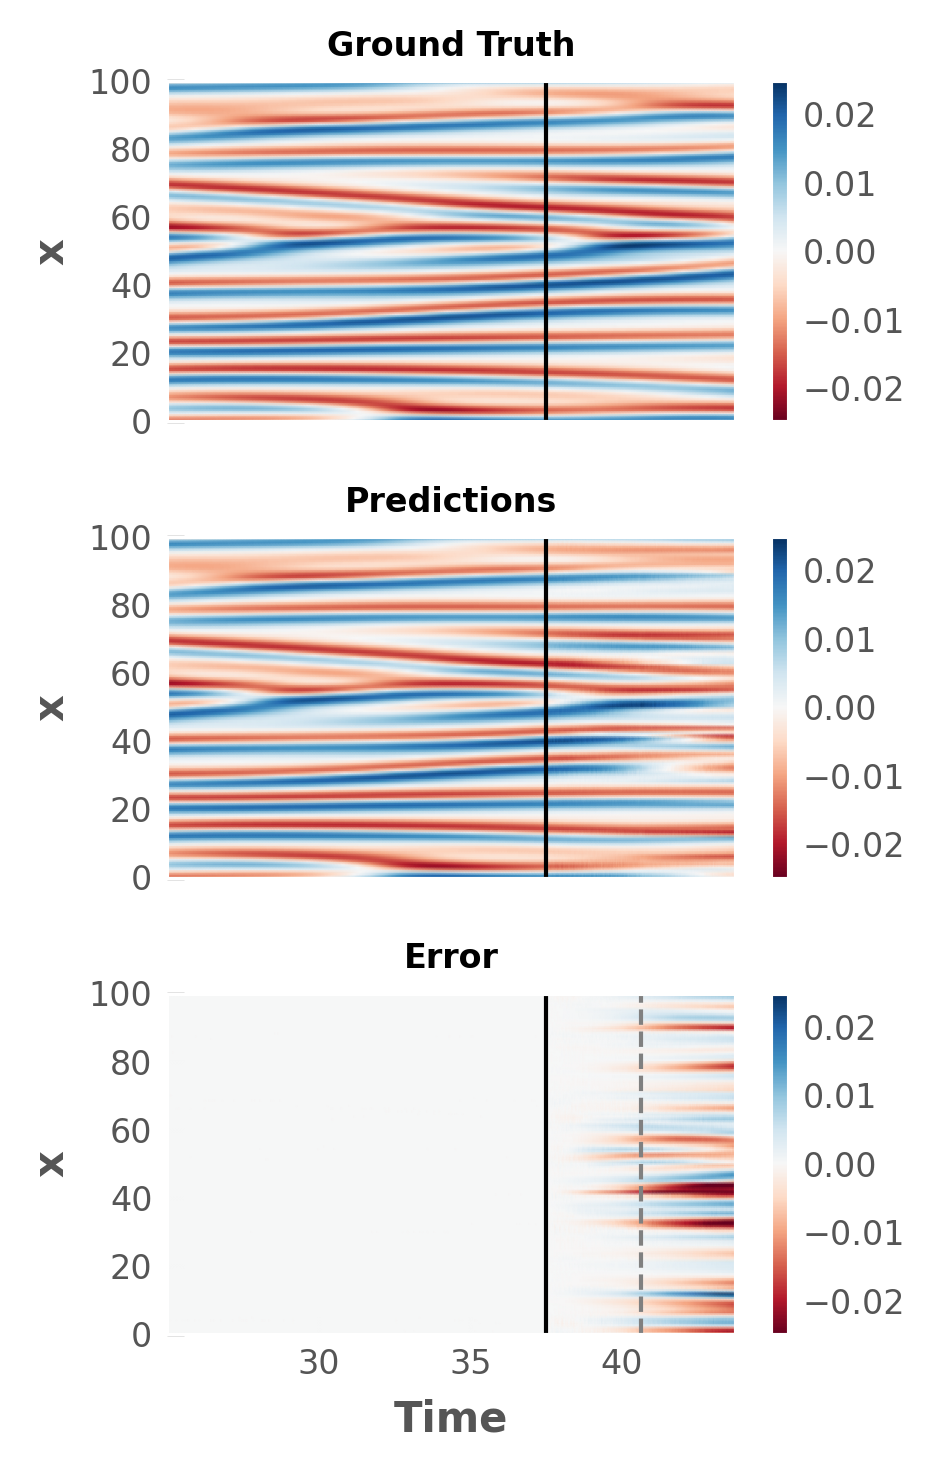

In [ ]:
our_spatial_vabs = plot_forecast(
    ts[start_time:end_time],
    grid,
    spatial_traj[start_time:end_time],
    preds_spatial,
    context_length=context_length,
    save_path=os.path.join(figs_save_dir, "ks_our_model_spatial.pdf"),
    cmap_name="RdBu",
    title_kwargs={"fontweight": "bold", "fontsize": 8},
    show_ticks=True,
    show_axes_labels=True,
    show_cbar=True,
    figsize=(3.2, 5),
    show_context=True,
)

### Chronos Finetune

In [ ]:
chronos_ft = ChronosPipeline.from_pretrained(
    f"{WORK_DIR}/checkpoints/chronos_t5_mini_ft-0/checkpoint-final",
    device_map=f"cuda:{device_rank}",
    torch_dtype=torch.float32,
)
chronos_ft

ChronosPipeline(tokenizer=<panda.chronos.model.MeanScaleUniformBins object at 0x77de587adac0>, model=ChronosModel(
  (model): T5ForConditionalGeneration(
    (shared): Embedding(4096, 384)
    (encoder): T5Stack(
      (embed_tokens): Embedding(4096, 384)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=384, out_features=512, bias=False)
                (k): Linear(in_features=384, out_features=512, bias=False)
                (v): Linear(in_features=384, out_features=512, bias=False)
                (o): Linear(in_features=512, out_features=384, bias=False)
                (relative_attention_bias): Embedding(32, 8)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseActDense(
                (

In [ ]:
def forecast_chronos(
    pipeline,
    trajectory: np.ndarray,
    context_length: int,
    chunk_size: int,
    **kwargs,
) -> np.ndarray:
    subchannel_predictions = []
    for i in trange(0, trajectory.shape[1] // chunk_size, leave=False):
        subpreds = forecast(
            pipeline,
            trajectory[:, i * chunk_size : (i + 1) * chunk_size],
            context_length,
            prediction_length=None,
            transpose=True,
            normalize=False,
            num_samples=1,
            **kwargs,
        )
        subchannel_predictions.append(subpreds)

    return np.concatenate(subchannel_predictions, axis=1)

In [ ]:
# # predict in frequency domain
# chronos_preds_freq = forecast_chronos(
#     chronos_ft, freq_traj[start_time:end_time], context_length, chunk_size=ks.dimension
# )

# # convert to spatial domain
# chronos_preds_freq_to_spatial = ks.to_spatial(chronos_preds_freq, N=ks.dimension)

In [ ]:
# plot_forecast(
#     ts[start_time:end_time],
#     grid,
#     spatial_traj[start_time:end_time],
#     chronos_preds_freq_to_spatial,
#     run_name="Chronos 20M SFT",
#     context_length=context_length,
#     save_path="../figures/ks_chronos_ft_freq_to_spatial.pdf",
#     v_abs=our_freq_vabs,
# )

In [ ]:
# spatial domain chronos prediction
chronos_preds_spatial = forecast_chronos(
    chronos_ft,
    spatial_traj[start_time:end_time],
    context_length,
    chunk_size=ks.dimension,
    deterministic=use_deterministic,
)

In [ ]:
plot_forecast(
    ts[start_time:end_time],
    grid,
    spatial_traj[start_time:end_time],
    chronos_preds_spatial,
    run_name="Chronos 20M SFT",
    context_length=context_length,
    save_path=os.path.join(figs_save_dir, "ks_chronos_ft_spatial.pdf"),
    v_abs=our_spatial_vabs,
    cmap_name="RdBu",
    title_kwargs={"fontweight": "bold", "fontsize": 8},
    show_ticks=False,
    show_cbar=False,
    figsize=(3, 5),
    show_context=True,
)

### Chronos Zeroshot

In [ ]:
chronos_zs = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-mini",
    device_map=f"cuda:{device_rank}",
    torch_dtype=torch.float32,
)
chronos_zs

/stor/home/jl82436/panda/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ChronosPipeline(tokenizer=<panda.chronos.model.MeanScaleUniformBins object at 0x77de5c7e9a00>, model=ChronosModel(
  (model): T5ForConditionalGeneration(
    (shared): Embedding(4096, 384)
    (encoder): T5Stack(
      (embed_tokens): Embedding(4096, 384)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=384, out_features=512, bias=False)
                (k): Linear(in_features=384, out_features=512, bias=False)
                (v): Linear(in_features=384, out_features=512, bias=False)
                (o): Linear(in_features=512, out_features=384, bias=False)
                (relative_attention_bias): Embedding(32, 8)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseActDense(
                (

In [ ]:
# chronos_zs_preds_freq = forecast_chronos(
#     chronos_zs, freq_traj[start_time:end_time], context_length, chunk_size=ks.dimension
# )

# # convert to spatial domain
# chronos_zs_preds_freq_to_spatial = ks.to_spatial(chronos_zs_preds_freq, N=ks.dimension)

In [ ]:
# plot_forecast(
#     ts[start_time:end_time],
#     grid,
#     spatial_traj[start_time:end_time],
#     chronos_zs_preds_freq_to_spatial,
#     run_name="Chronos 20M",
#     context_length=context_length,
#     save_path="../figures/ks_chronos_zs_freq_to_spatial.pdf",
#     v_abs=our_freq_vabs,
# )

In [ ]:
# spatial domain chronos prediction
chronos_zs_preds_spatial = forecast_chronos(
    chronos_zs,
    spatial_traj[start_time:end_time],
    context_length,
    chunk_size=ks.dimension,
    deterministic=use_deterministic,
)

  0%|          | 0/1 [00:00<?, ?it/s]/stor/home/jl82436/panda/panda/chronos/pipeline.py:162: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


In [ ]:
plot_forecast(
    ts[start_time:end_time],
    grid,
    spatial_traj[start_time:end_time],
    chronos_zs_preds_spatial,
    run_name="Chronos 20M",
    context_length=context_length,
    save_path=os.path.join(figs_save_dir, "ks_chronos_zs_spatial.pdf"),
    v_abs=our_spatial_vabs,
    cmap_name="RdBu",
    title_kwargs={"fontweight": "bold", "fontsize": 8},
    show_ticks=False,
    show_cbar=False,
    figsize=(3, 5),
    show_context=True,
)

### FNO

In [ ]:
from neuralop.models import FNO


@torch.no_grad()
def fno_rollout(context: np.ndarray, num_steps: int, model: torch.nn.Module, lookback: int) -> torch.Tensor:
    stand_context = safe_standardize(context, axis=0)
    ic = torch.tensor(stand_context[-lookback:]).float().to(device).unsqueeze(0)
    traj = [ic]
    state = ic.clone()
    for _ in range(num_steps):
        pred = model(state)
        traj.append(pred)
        state = torch.cat([state[:, :-1, :], pred], dim=1)
    pred = torch.cat(traj, dim=1)[:, lookback:, :].cpu().numpy().squeeze()
    traj = np.concatenate([stand_context, pred], axis=0)
    return safe_standardize(traj, axis=0, context=context, denormalize=True)


lookback = 1
operator = FNO(n_modes=(256,), hidden_channels=128, n_layers=5, in_channels=lookback, out_channels=1).to(device)
operator.load_state_dict(
    torch.load(
        f"{WORK_DIR}/checkpoints/KS-baselines-full/best_model_state_dict.pt", map_location=device, weights_only=False
    )
)
operator.eval()

FNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-4): 5 x SpectralConv(
        (weight): DenseTensor(shape=torch.Size([128, 128, 129]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-4): 5 x Flattened1dConv(
        (conv): Conv1d(128, 128, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-4): 5 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
          (1): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-4): 5 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(2, 256, kernel_size=(1,), stride=(1,))
      (1): Conv1d(256, 128, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
      (1): Conv1d(256, 1, ker

In [30]:
fno_preds_spatial = fno_rollout(
    spatial_traj[start_time : start_time + context_length],
    end_time - start_time - context_length,
    operator,
    lookback,
)

0.024825844346193532

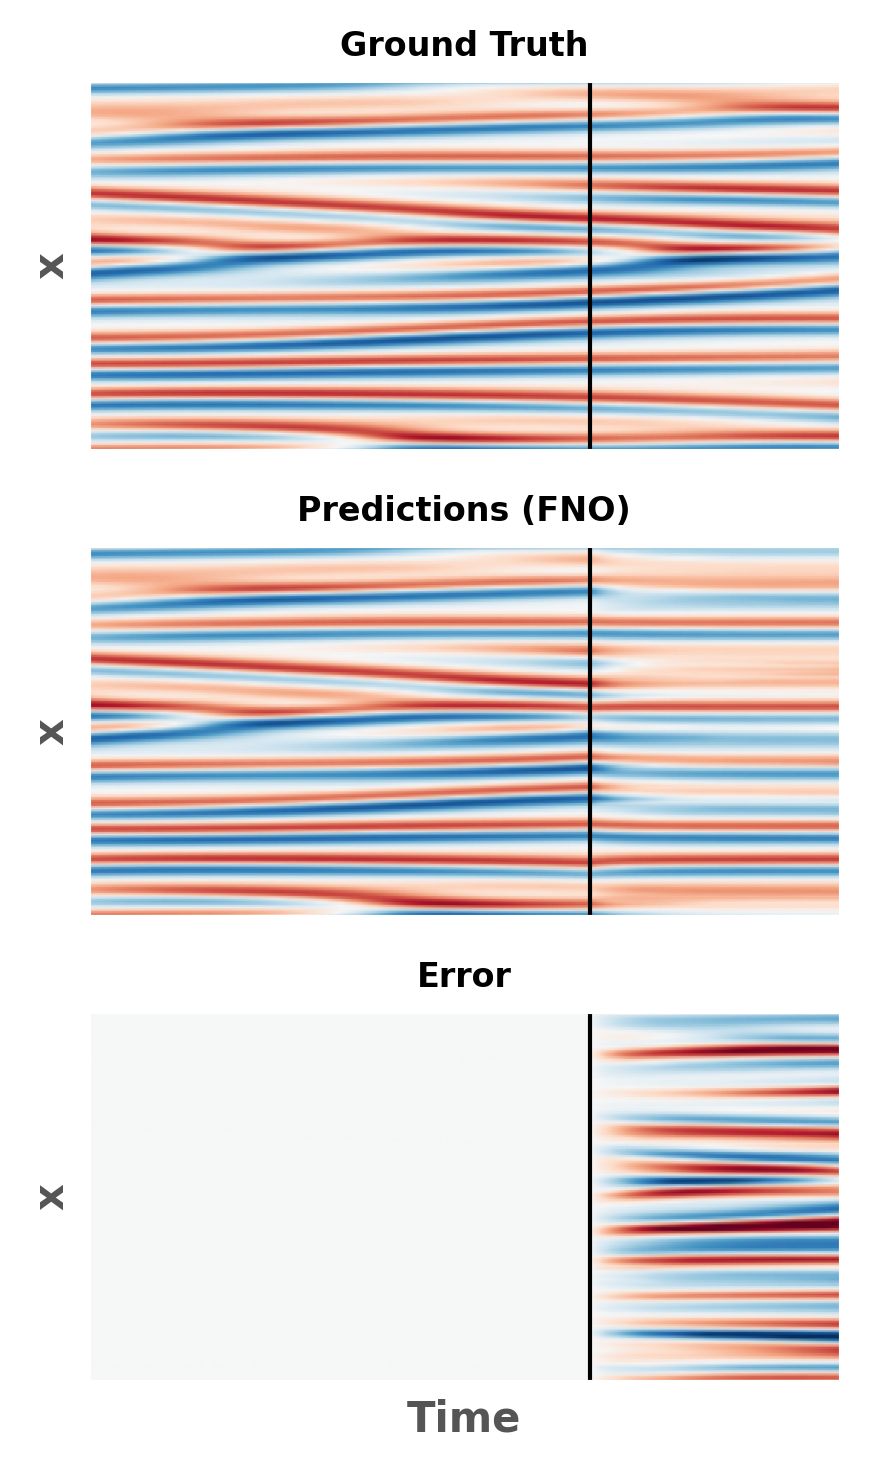

In [31]:
plot_forecast(
    ts[start_time:end_time],
    grid,
    spatial_traj[start_time:end_time],
    fno_preds_spatial,
    run_name="FNO",
    context_length=context_length,
    save_path=os.path.join(figs_save_dir, "ks_fno_spatial.pdf"),
    v_abs=our_spatial_vabs,
    cmap_name="RdBu",
    title_kwargs={"fontweight": "bold", "fontsize": 8},
    show_ticks=False,
    show_cbar=False,
    figsize=(3, 5),
    show_context=True,
    draw_prediction_horizon_line=False,
)

### DeepONet

In [ ]:
import deepxde as dde


@torch.no_grad()
def deeponet_rollout(context: np.ndarray, num_steps: int, model: torch.nn.Module, xs: np.ndarray):
    stand_context = safe_standardize(context, axis=0)
    ic = torch.tensor(stand_context[-1]).float().to(device).unsqueeze(0)
    traj = [ic]
    state = ic.clone()
    for _ in range(num_steps):
        state = model((state, xs))
        traj.append(state)
    pred = torch.cat(traj, dim=0)[1:].cpu().numpy().squeeze()
    traj = np.concatenate([stand_context, pred], axis=0)
    return safe_standardize(traj, axis=0, context=context, denormalize=True)


hidden_dim = 128
n_layers = 6
net = dde.nn.DeepONetCartesianProd(
    [ks.dimension] + n_layers * [hidden_dim],
    [1] + n_layers * [hidden_dim],
    "gelu",
    "Glorot uniform",
).to(device)
state_dict = torch.load(
    f"{WORK_DIR}/checkpoints/KS-baselines-full/deeponet.pt", map_location=device, weights_only=False
)["model_state_dict"]
net.load_state_dict(state_dict)
net.eval()
torch.set_default_device("cpu")

In [33]:
xs = np.linspace(0, ks.L, ks.dimension).astype(np.float32).reshape(-1, 1)  # (N,1)
xs = torch.from_numpy(xs).float().to(device)

don_preds_spatial = deeponet_rollout(
    spatial_traj[start_time : start_time + context_length], end_time - start_time - context_length, net, xs
)

0.024825844346193532

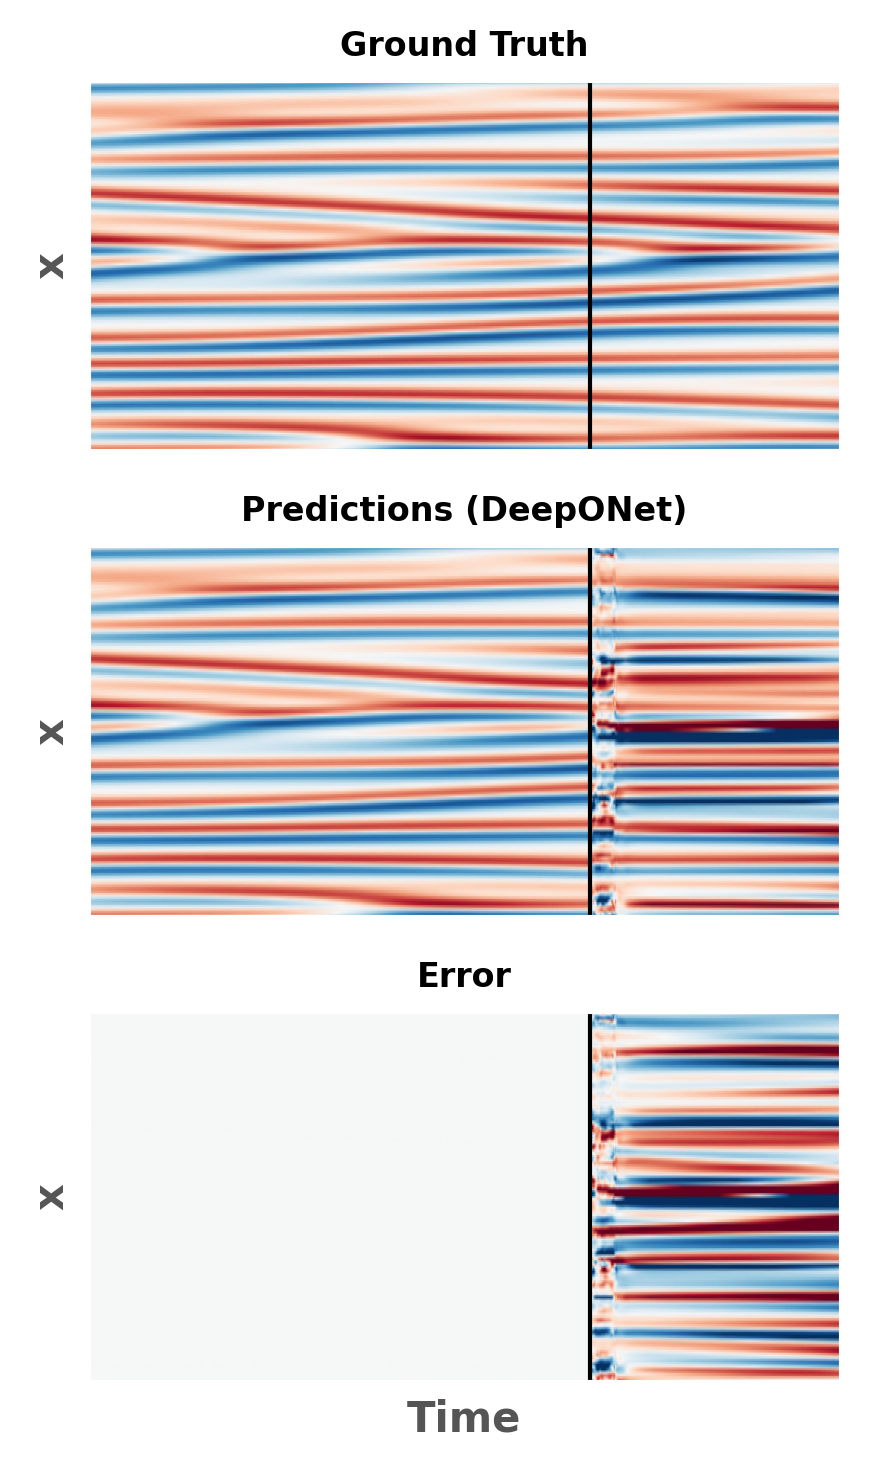

In [34]:
plot_forecast(
    ts[start_time:end_time],
    grid,
    spatial_traj[start_time:end_time],
    don_preds_spatial,
    run_name="DeepONet",
    context_length=context_length,
    save_path=os.path.join(figs_save_dir, "ks_don_spatial.pdf"),
    v_abs=our_spatial_vabs,
    cmap_name="RdBu",
    title_kwargs={"fontweight": "bold", "fontsize": 8},
    show_ticks=False,
    show_cbar=False,
    figsize=(3, 5),
    show_context=True,
    draw_prediction_horizon_line=False,
)

# Rollout Evaluation

In [35]:
# repeated for convenience
start_time = 1024
end_time = 2048
context_length = 512

In [36]:
n_runs = 40
parent_rng = np.random.default_rng(12)
rng_stream = parent_rng.spawn(n_runs)

predict_spatial = True  # predict in spatial domain instead of frequency domain
convert_to_spatial = False  # if prediction in freq domain, convert to spatial domain

In [37]:
save_dir = "../outputs/kuramoto_sivashinsky"
os.makedirs(save_dir, exist_ok=True)

In [38]:
traj_path = os.path.join(save_dir, f"trajectories_{n_runs}.npy")
if os.path.exists(traj_path):
    trajectories = np.load(traj_path, allow_pickle=True)
else:
    trajectories = []
    for rng in rng_stream:
        ic = 0.1 * rng.normal(size=(ks.dimension,))
        teval = np.linspace(0, tfinal, 4096)
        sol = solve_ivp(ks.rhs, (0, tfinal), ic, method="DOP853", t_eval=teval, rtol=1e-8, atol=1e-8)
        ts, freq_traj = sol.t, sol.y.T
        if predict_spatial:
            trajectories.append(ks.to_spatial(freq_traj, N=ks.dimension))
        else:
            trajectories.append(freq_traj)
    np.save(traj_path, trajectories)

In [39]:
time_intervals = [(0, end) for end in np.arange(64, 512 + 64, 64)]

In [40]:
def compute_pred_error(prediction, ground_truth, time_intervals: list[tuple[int, int]]):
    pred_error_dict = {}
    for start, end in time_intervals:
        error_dict = compute_metrics(
            prediction[start:end],
            ground_truth[start:end],
            include=["mae", "mse", "smape"],
        )
        pred_error_dict[start, end] = error_dict
    return pred_error_dict


def get_mean_median_std_metrics_dicts_rollout(
    predictions: list[np.ndarray],
    trajectories: list[np.ndarray],
    time_intervals: list[tuple[int, int]],
):
    pred_error_dict_lst = []
    for preds, traj in zip(predictions, trajectories):
        actual_preds = preds[context_length:]
        actual_gt = traj[start_time:end_time][context_length:]
        pred_error_dict_lst.append(compute_pred_error(actual_preds, actual_gt, time_intervals))

    metrics_lst = ["mse", "mae", "smape"]
    metric_dict = defaultdict(dict)
    for time_interval in pred_error_dict_lst[0].keys():
        for metric in metrics_lst:
            values = []
            for pred_error_dict in pred_error_dict_lst:
                values.append(pred_error_dict[time_interval][metric])
            values = np.array(values)
            mean_metric = np.mean(values, axis=0)
            median_metric = np.median(values, axis=0)
            std_metric = np.std(values, axis=0)
            metric_dict[time_interval][metric] = {
                "mean": mean_metric,
                "median": median_metric,
                "std": std_metric,
            }

    mean_metrics_dict = defaultdict(dict)
    for time_interval in time_intervals:
        for metric in metrics_lst:
            mean_metrics_dict[metric][time_interval] = metric_dict[time_interval][metric]["mean"]

    median_metrics_dict = defaultdict(dict)
    for time_interval in time_intervals:
        for metric in metrics_lst:
            median_metrics_dict[metric][time_interval] = metric_dict[time_interval][metric]["median"]

    std_metrics_dict = defaultdict(dict)
    for time_interval in time_intervals:
        for metric in metrics_lst:
            std_metrics_dict[metric][time_interval] = metric_dict[time_interval][metric]["std"]

    return mean_metrics_dict, median_metrics_dict, std_metrics_dict

### Our Model

In [41]:
panda_pred_path = os.path.join(save_dir, f"{run_name}_preds_{n_runs}.npy")
if os.path.exists(panda_pred_path):
    preds = np.load(panda_pred_path, allow_pickle=True)
else:
    preds = []
    for traj in tqdm(trajectories):
        sample_pred = forecast(
            pipeline,
            traj[start_time:end_time],
            context_length,
            prediction_length=None,
            normalize=True,
            sliding_context=True,
        )
        if convert_to_spatial and not predict_spatial:
            sample_pred = ks.to_spatial(sample_pred, N=ks.dimension)
        preds.append(sample_pred)
    np.save(panda_pred_path, preds)

### Chronos Finetune

In [42]:
use_deterministic = True  # for Chronos

In [43]:
chronos_ft_pred_path = os.path.join(
    save_dir,
    f"chronos_ft_preds_{n_runs}{'' if use_deterministic else '_nondeterministic'}.npy",
)
if os.path.exists(chronos_ft_pred_path):
    chronos_ft_preds = np.load(chronos_ft_pred_path, allow_pickle=True)
else:
    chronos_ft_preds = []

    for traj in tqdm(trajectories):
        chronos_ft_sample_pred = forecast_chronos(
            chronos_ft,
            traj[start_time:end_time],
            context_length,
            chunk_size=ks.dimension,
            deterministic=use_deterministic,
        )
        if convert_to_spatial and not predict_spatial:
            chronos_ft_sample_pred = ks.to_spatial(chronos_ft_sample_pred, N=ks.dimension)
        chronos_ft_preds.append(chronos_ft_sample_pred)
    np.save(chronos_ft_pred_path, chronos_ft_preds)

### Chronos Zeroshot

In [44]:
chronos_zs_pred_path = os.path.join(
    save_dir,
    f"chronos_zs_preds_{n_runs}{'' if use_deterministic else '_nondeterministic'}.npy",
)
if os.path.exists(chronos_zs_pred_path):
    chronos_zs_preds = np.load(chronos_zs_pred_path, allow_pickle=True)
else:
    chronos_zs_preds = []
    for traj in tqdm(trajectories):
        chronos_zs_sample_pred = forecast_chronos(
            chronos_zs,
            traj[start_time:end_time],
            context_length,
            chunk_size=ks.dimension,
            deterministic=use_deterministic,
        )
        if convert_to_spatial and not predict_spatial:
            chronos_zs_sample_pred = ks.to_spatial(chronos_zs_sample_pred, N=ks.dimension)
        chronos_zs_preds.append(chronos_zs_sample_pred)
    np.save(chronos_zs_pred_path, chronos_zs_preds)

### FNO

In [45]:
fno_pred_path = os.path.join(save_dir, f"fno_preds_{n_runs}.npy")
if os.path.exists(fno_pred_path):
    fno_preds = np.load(fno_pred_path, allow_pickle=True)
else:
    fno_preds = []
    for traj in tqdm(trajectories):
        fno_sample_pred = fno_rollout(
            traj[start_time : start_time + context_length],
            end_time - start_time - context_length,
            operator,
            lookback=lookback,
        )
        fno_preds.append(fno_sample_pred)
    np.save(fno_pred_path, fno_preds)

100%|██████████| 40/40 [00:54<00:00,  1.37s/it]


### DeepONet

In [46]:
don_pred_path = os.path.join(save_dir, f"don_preds_{n_runs}.npy")
if os.path.exists(don_pred_path):
    don_preds = np.load(don_pred_path, allow_pickle=True)
else:
    xs = np.linspace(0, ks.L, ks.dimension).astype(np.float32).reshape(-1, 1)  # (N,1)
    xs = torch.from_numpy(xs).float().to(device)
    don_preds = []
    for traj in tqdm(trajectories):
        don_sample_pred = deeponet_rollout(
            traj[start_time : start_time + context_length], end_time - start_time - context_length, net, xs
        )
        don_preds.append(don_sample_pred)
    np.save(don_pred_path, don_preds)

100%|██████████| 40/40 [00:08<00:00,  4.59it/s]


### Plot Results

In [47]:
markers = ["o", "s", "v", "^", "x"]

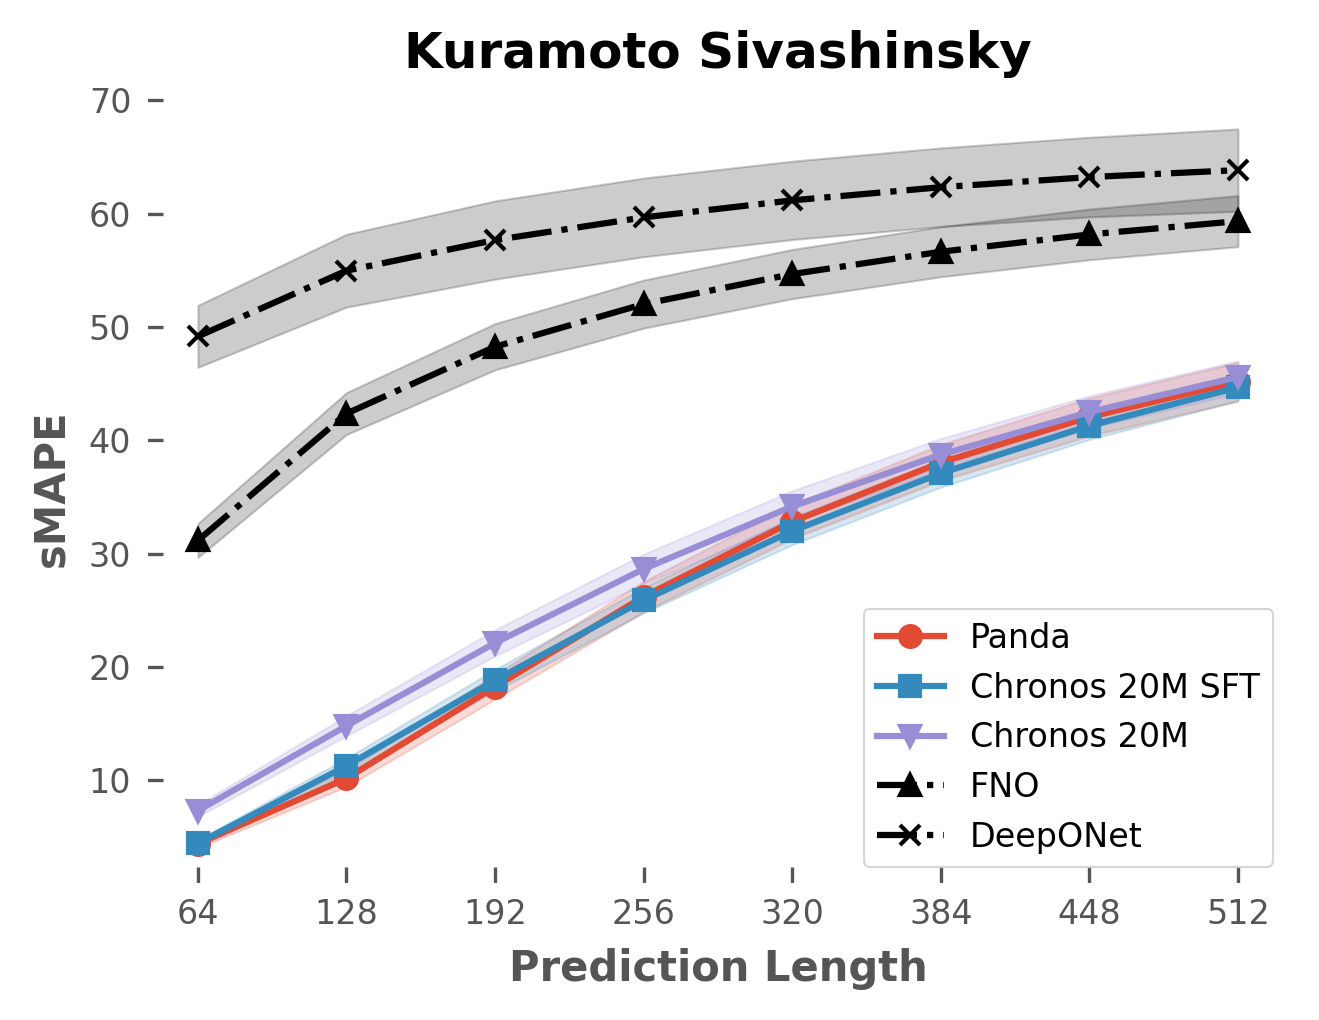

In [48]:
end_times = [end_time for _, end_time in time_intervals]
for metric_to_plot, title_metric_name in [("smape", "sMAPE")]:
    fig = plt.figure(figsize=(4.5, 3.5))
    for i, (run_name, plist) in enumerate(
        zip(
            ["Panda", "Chronos 20M SFT", "Chronos 20M", "FNO", "DeepONet"],
            [preds, chronos_ft_preds, chronos_zs_preds, fno_preds, don_preds],
        )
    ):
        mean_metrics_dict, median_metrics_dict, std_metrics_dict = get_mean_median_std_metrics_dicts_rollout(
            plist, trajectories, time_intervals
        )
        mean_vals = np.array(list(mean_metrics_dict[metric_to_plot].values()))
        std_vals = np.array(list(std_metrics_dict[metric_to_plot].values()))
        color = "k" if run_name in ("FNO", "DeepONet") else plt.gca()._get_lines.get_next_color()
        plt.plot(
            end_times,
            list(mean_vals),
            label=run_name,
            marker=markers[i],
            linestyle="-." if run_name in ("FNO", "DeepONet") else "-",
            color=color,
        )
        plt.fill_between(
            end_times,
            np.array(list(mean_vals)) - np.array(list(std_vals)) / np.sqrt(len(time_intervals)),
            np.array(list(mean_vals)) + np.array(list(std_vals)) / np.sqrt(len(time_intervals)),
            alpha=0.2,
            color=color,
        )
    plt.xticks(end_times)
    plt.legend(loc="lower right", frameon=True)
    plt.title("Kuramoto Sivashinsky", fontweight="bold")
    plt.ylabel(f"{title_metric_name}", fontweight="bold")
    plt.xlabel("Prediction Length", fontweight="bold")
    plt.tight_layout()
    plt.savefig(
        os.path.join(figs_save_dir, f"ks_all_models_{metric_to_plot}.pdf"),
        bbox_inches="tight",
    )
    plt.show()
    plt.close()

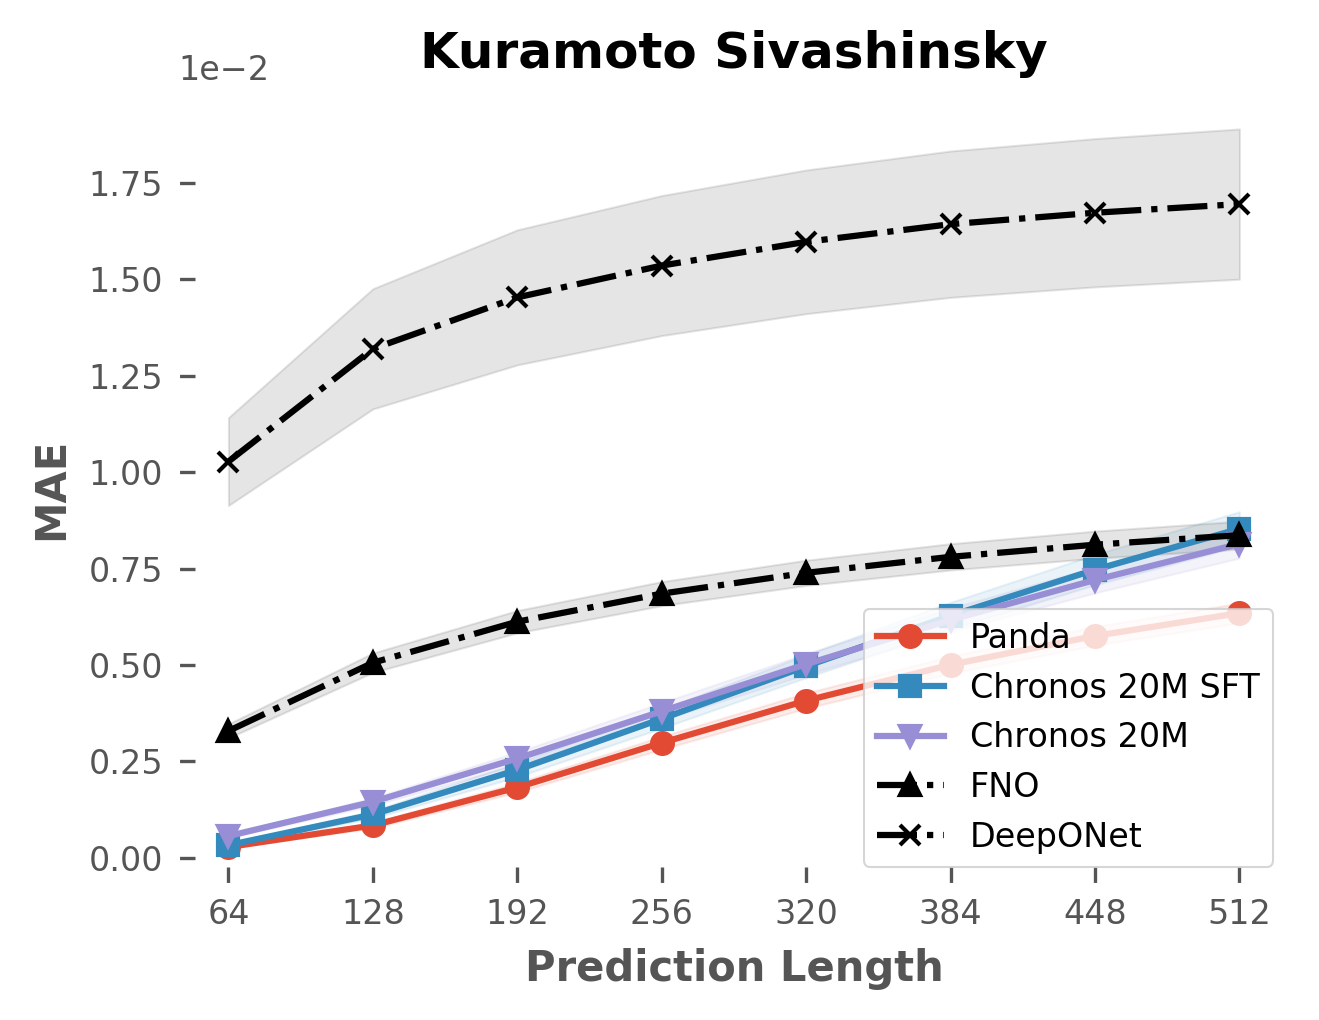

In [49]:
end_times = [end_time for _, end_time in time_intervals]
for metric_to_plot, title_metric_name in [("mae", "MAE")]:
    plt.figure(figsize=(4.5, 3.5))
    for i, (run_name, plist) in enumerate(
        zip(
            ["Panda", "Chronos 20M SFT", "Chronos 20M", "FNO", "DeepONet"],
            [preds, chronos_ft_preds, chronos_zs_preds, fno_preds, don_preds],
        )
    ):
        mean_metrics_dict, median_metrics_dict, std_metrics_dict = get_mean_median_std_metrics_dicts_rollout(
            plist, trajectories, time_intervals
        )
        mean_vals = np.array(list(mean_metrics_dict[metric_to_plot].values()))
        std_vals = np.array(list(std_metrics_dict[metric_to_plot].values()))
        color = "k" if run_name in ("FNO", "DeepONet") else plt.gca()._get_lines.get_next_color()
        plt.plot(
            end_times,
            list(mean_vals),
            label=run_name,
            marker=markers[i],
            linestyle="-." if run_name in ("FNO", "DeepONet") else "-",
            color=color,
        )
        plt.fill_between(
            end_times,
            np.array(list(mean_vals)) - np.array(list(std_vals)) / np.sqrt(len(time_intervals)),
            np.array(list(mean_vals)) + np.array(list(std_vals)) / np.sqrt(len(time_intervals)),
            alpha=0.1,
            color=color,
        )
    plt.xticks(end_times)
    plt.legend(loc="lower right", frameon=True)
    plt.title("Kuramoto Sivashinsky", fontweight="bold")
    plt.ylabel(f"{title_metric_name}", fontweight="bold")
    plt.xlabel("Prediction Length", fontweight="bold")
    plt.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))
    plt.tight_layout()
    plt.savefig(
        os.path.join(figs_save_dir, f"ks_all_models_{metric_to_plot}.pdf"),
        bbox_inches="tight",
    )
    plt.show()
    plt.close()